# 1. Particles distribution and Emission region

In this tutorial, we describe the non-thermal particle distributions available in `agnpy` and illustrate how to define the region containing and accelerating them, usually referred to as _emission_ region.

In [1]:
# import numpy, astropy and matplotlib for basic functionalities
import numpy as np
import astropy.units as u
from astropy.constants import m_e, m_p, c
from astropy.coordinates import Distance
import matplotlib.pyplot as plt

In [2]:
# import agnpy classes
from agnpy.spectra import PowerLaw, BrokenPowerLaw, LogParabola
from agnpy.emission_regions import Blob
from agnpy.utils.plot import load_mpl_rc

load_mpl_rc()  # adopt agnpy plotting style

## 1.1. Definition of particles distributions

The `agnpy.spectra` module provides classes describing the energy distributions of particles accelerated in the jets. The energy distribution is commonly represented by an analytical function, usually a power law (and its broken, curved, and cut-off variations), returning the volume density of particles, $n [{\rm cm}]^{-3}$, as a function of their Lorentz factor, $\gamma$. For the simplest power law:

\begin{equation}
n(\gamma) = k\,\gamma^{-p} \, H(\gamma; \gamma_{\rm min}, \gamma_{\rm max}),
\end{equation}

where $k$ is an amplitude in ${\rm cm}^{-3}$, $p$ the spectral index, and the Heaviside function ensures null values outside the range $[\gamma_{\rm min}, \gamma_{\rm max}]$. Several analytical functions are available, along with a function that interpolates an series of $n [{\rm cm}]^{-3}$ values.

We illustrate, in the following, how to declare an electron and a proton particle distributions

In [3]:
# define an electron distribution
n_e = BrokenPowerLaw(
    k=1e-8 * u.Unit("cm-3"),
    p1=1.9,
    p2=2.6,
    gamma_b=1e4,
    gamma_min=10,
    gamma_max=1e6,
    mass=m_e,
)

# define a proton distribution
n_p = PowerLaw(k=0.1 * u.Unit("cm-3"), p=2.3, gamma_min=10, gamma_max=1e6, mass=m_p)

As we can see, the parameter `mass` distinguishes the particle type.

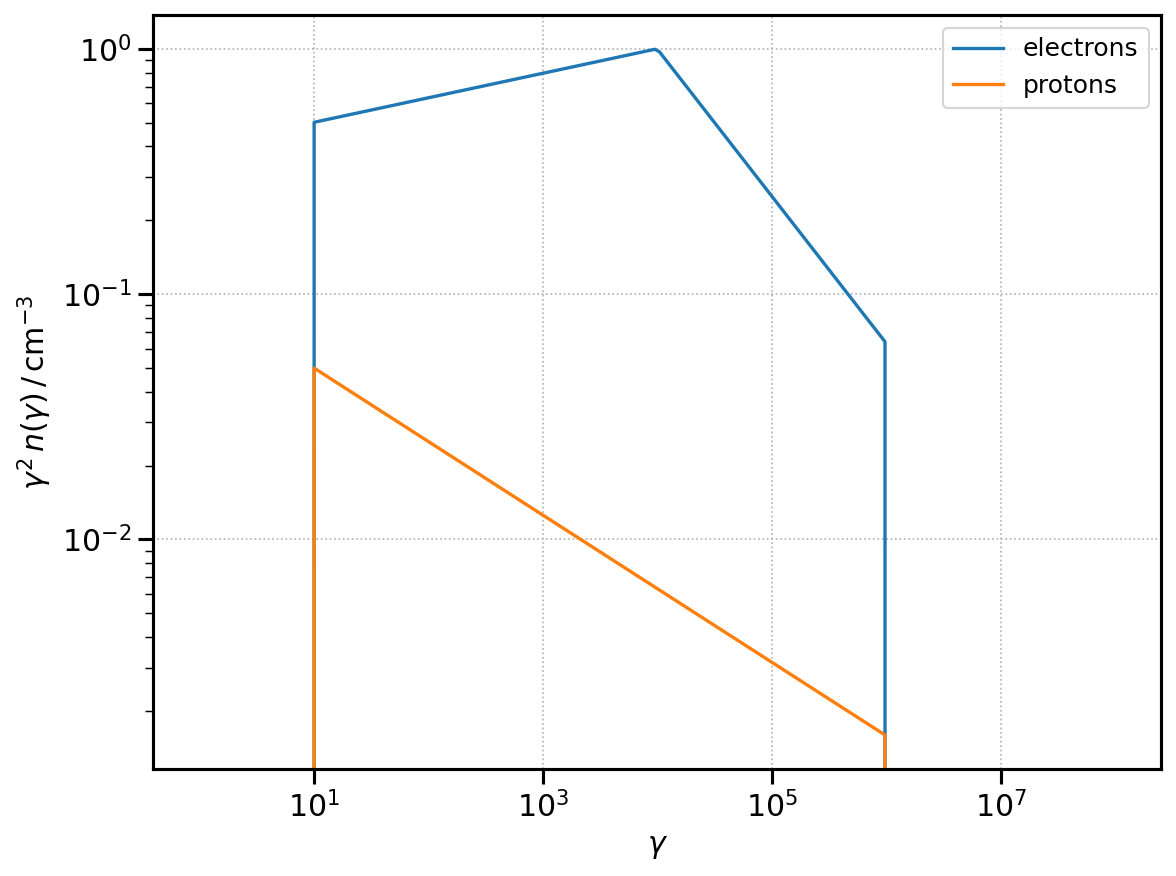

In [16]:
# we can plot the particles distribution defined above
# we can represent them multiplied by an arbitrary power of gamma
fig, ax = plt.subplots()

n_e.plot(ax=ax, gamma_power=2, label="electrons")
n_p.plot(ax=ax, gamma_power=2, label="protons")

ax.legend()
plt.show()

## 1.1.1. Different methods to intialise the particle distribution
Authors use different approaches to define the particles distribution $n(\gamma)$.
A __normalisation__ of the distribution is often provided, which can be of different types.

Some authors use an _integral_ normalisation. That is, the normalisation value provided might represent:

- the total volume density, $n_{\rm tot} = \int {\rm d \gamma} \, n(\gamma)$, in ${\rm cm}^{-3}$;
- the total energy density, $u_{\rm tot} =  m c^2 \int {\rm d \gamma} \, \gamma \, n(\gamma)$, in ${\rm erg}\,{\rm cm}^{-3}$;
- the total energy in particles, $W = m c^2 \, \int {\rm d \gamma} \, \gamma \, N(\gamma)$, in ${\rm erg}$.

Where, in the last expression $N$, is the number density ($N = V_b n$).

Others authors use a *differential* normalisation, that is, the normalisation value provided directly represents the constant, $k$, multiplying the analytical function.

Finally, some authors use a normalisation *at* $\gamma=1$, that means the normalisation value provided represents
the value of the denisty at $\gamma=1$.

We offer all of the aforementioned alternatives to initialise a particles distribution in `agnpy`.
Here follows an example illustrating them:

In [5]:
# initialise the electron distribution, let us use the same spectral parameters
# for all the distributions
p = 2.3
q = 0.2
gamma_0 = 1e3
gamma_min = 1
gamma_max = 1e6

# - from total density
n_tot = 1e-3 * u.Unit("cm-3")

n_1 = LogParabola.from_total_density(
    n_tot, p=p, q=q, gamma_0=gamma_0, gamma_min=gamma_min, gamma_max=gamma_max, mass=m_e
)

# check total volume density
gamma = np.logspace(0, 7)
integral = np.trapz(n_1(gamma), gamma)
print(f"{integral:.2e}")

1.03e-03 1 / cm3


In [6]:
# - from total energy density
u_tot = 1e-8 * u.Unit("erg cm-3")

n_2 = LogParabola.from_total_energy_density(
    u_tot, p=p, q=q, gamma_0=gamma_0, gamma_min=gamma_min, gamma_max=gamma_max, mass=m_e
)

# check total energy density
integral = m_e * c**2 * np.trapz(gamma * n_2(gamma), gamma)
print(f"{integral.to('erg cm-3'):.2e}")

1.02e-08 erg / cm3


In [7]:
# - from total energy, we need also the volume to convert to an energy density
W = 1e40 * u.erg
V_b = 4 / 3 * np.pi * (1e16 * u.cm) ** 3

n_3 = LogParabola.from_total_energy(
    W,
    V_b,
    p=p,
    q=q,
    gamma_0=gamma_0,
    gamma_min=gamma_min,
    gamma_max=gamma_max,
    mass=m_e,
)

# check total energy density
integral = V_b * m_e * c**2 * np.trapz(gamma * n_3(gamma), gamma)
print(f"{integral.to('erg'):.2e}")

1.02e+40 erg


In [8]:
# - from the denisty at gamma = 1
n_gamma_1 = 1e-4 * u.Unit("cm-3")

n_4 = LogParabola.from_density_at_gamma_1(
    n_gamma_1,
    p=p,
    q=q,
    gamma_0=gamma_0,
    gamma_min=gamma_min,
    gamma_max=gamma_max,
    mass=m_e,
)

# check the distribution at gamma=1
print(n_4(1))

0.0001 1 / cm3


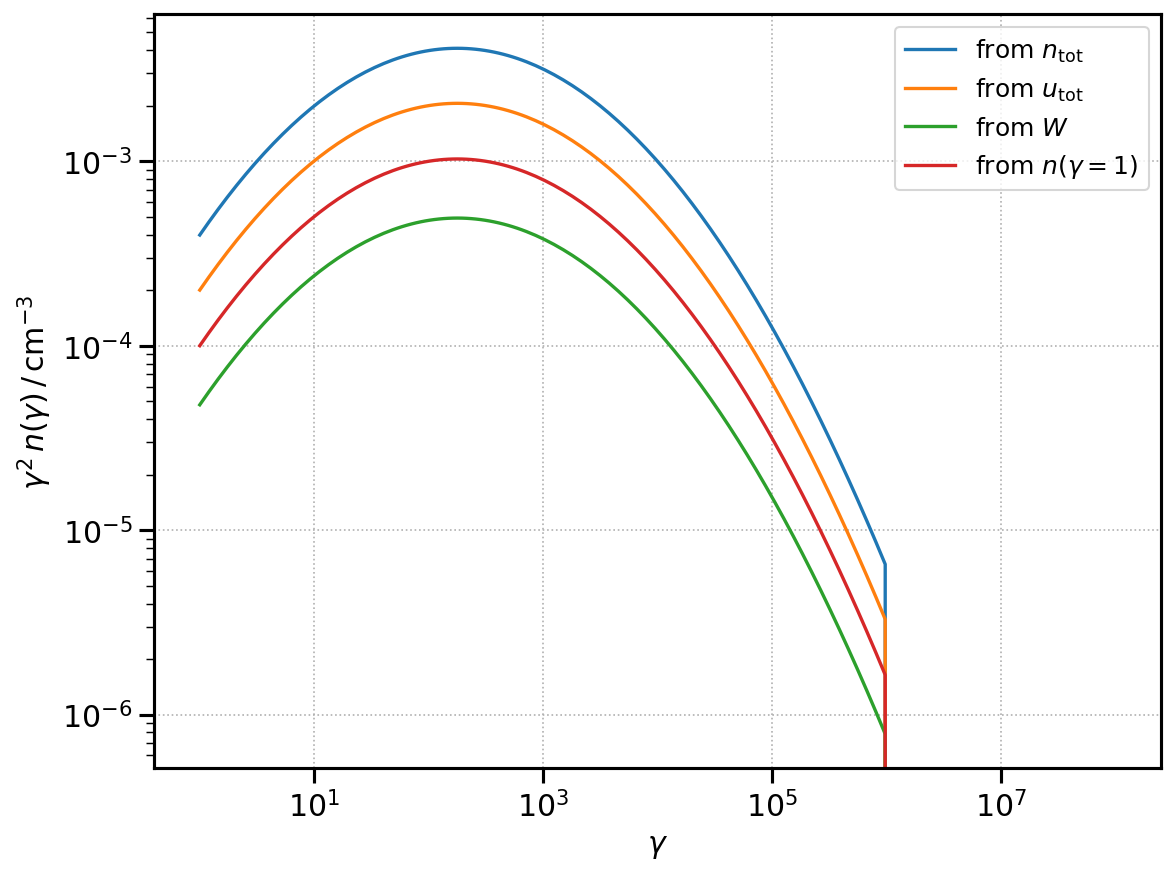

In [9]:
# let us plot all the particles distributions
fig, ax = plt.subplots()

n_1.plot(ax=ax, gamma_power=2, label="from " + r"$n_{\rm tot}$")
n_2.plot(ax=ax, gamma_power=2, label="from " + r"$u_{\rm tot}$")
n_3.plot(ax=ax, gamma_power=2, label="from " + r"$W$")
n_4.plot(ax=ax, gamma_power=2, label="from " + r"$n(\gamma=1)$")

ax.legend()
plt.show()

## 1.2. Definition of the emission region

The only emission region currently available in the package is a simple spherical plasmoid, commonly referred to as _blob_ in the literature.

The blob represents a spherical region of plasma streaming along the jet.
The physical quantities _needed_ to define the `~agnpy.emission_regions.Blob` are:

- its radius, $R_{\rm b}$;
- its distance from the observer, expressed through the redshift $z$ of the host galaxy;
- the Doppler factor produced by the motion of the jet, $\delta_{\rm D} = \frac{1}{\Gamma(1 - \beta\cos(\theta_{\rm s}))}$. Where $\beta$ is the blob relativistic velocity, $\Gamma$ its bulk Lorentz factor, and $\theta_{\rm s}$ the angle between the jet axis and the observer's line of sight;
- the bulk Lorentz factor of the jet, $\Gamma$;
- the magnetic field tangled to the blob, $B$, assumed to be uniform; 
- the energy distributions of particles accelerated in the blob.

Follows a snippet initialising the `Blob` with its physical quantities and an electrons distribution.

In [10]:
# set the quantities defining the blob
R_b = 1e16 * u.cm
z = Distance(1e27, unit=u.cm).z
delta_D = 10
Gamma = 10
B = 1 * u.G

# electron distribution
n_e = BrokenPowerLaw(
    k=1e-8 * u.Unit("cm-3"),
    p1=1.9,
    p2=2.6,
    gamma_b=1e4,
    gamma_min=10,
    gamma_max=1e6,
    mass=m_e,
)

blob = Blob(R_b, z, delta_D, Gamma, B, n_e=n_e)

In [11]:
# we can always print the blob to check the quantities initialised
print(blob)

* Spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - t_var (variability time scale): 4.13e-01 d
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07 redshift
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electrons energy distribution
 - broken power law
 - k: 1.00e-08 1 / cm3
 - p1: 1.90
 - p2: 2.60
 - gamma_b: 1.00e+04
 - gamma_min: 1.00e+01
 - gamma_max: 1.00e+06



we can also add a proton distribution to the blob

In [12]:
# add a proton energy distribution
n_p = PowerLaw(k=0.1 * u.Unit("cm-3"), p=2.3, gamma_min=10, gamma_max=1e6, mass=m_p)
blob = Blob(R_b, z, delta_D, Gamma, B, n_e=n_e, n_p=n_p)

print(blob)

* Spherical emission region
 - R_b (radius of the blob): 1.00e+16 cm
 - t_var (variability time scale): 4.13e-01 d
 - V_b (volume of the blob): 4.19e+48 cm3
 - z (source redshift): 0.07 redshift
 - d_L (source luminosity distance):1.00e+27 cm
 - delta_D (blob Doppler factor): 1.00e+01
 - Gamma (blob Lorentz factor): 1.00e+01
 - Beta (blob relativistic velocity): 9.95e-01
 - theta_s (jet viewing angle): 5.74e+00 deg
 - B (magnetic field tangled to the jet): 1.00e+00 G
 - xi (coefficient for 1st order Fermi acceleration) : 1.00e+00
* electrons energy distribution
 - broken power law
 - k: 1.00e-08 1 / cm3
 - p1: 1.90
 - p2: 2.60
 - gamma_b: 1.00e+04
 - gamma_min: 1.00e+01
 - gamma_max: 1.00e+06
* protons energy distribution
 - power law
 - k: 1.00e-01 1 / cm3
 - p: 2.30
 - gamma_min: 1.00e+01
 - gamma_max: 1.00e+06



The blob instance contains more quantities than those we specified to initialize it. Once created, we can check, for example:

In [13]:
print("total particle number:", f"{blob.N_e_tot:.2e}")
print("total particle density:", f"{blob.n_e_tot:.2e}")
print("total energy in electrons:", f"{blob.W_e:.2e}")
print("total energy in protons:", f"{blob.W_p:.2e}")

total particle number: 2.33e+47
total particle density: 5.57e-02 1 / cm3
total energy in electrons: 2.25e+43 erg
total energy in protons: 1.02e+45 erg


We can also check the jet power in  kinetic energy of the particles $P_{\rm jet, ke}$ and in magnetic field $P_{\rm jet, B}$ (the power needed to expel a magnetic-field-laden plasma). The equilibrium between these two quantities defines a condition referred to as *equipartition*.

In [14]:
blob.P_jet_ke

<Quantity 4.6624287e+41 erg / s>

In [15]:
blob.P_jet_B

<Quantity 7.45724324e+43 erg / s>